In [2]:
import numpy as np
import pandas as pd
import cv2
import csv
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline

In [3]:
from model import get_model
from generator import generator, get_image

Using TensorFlow backend.


In [15]:
base_path = '../../datasets/german_traffic_signs/'
train_path = base_path + 'imgs/train'
test_path = base_path + 'imgs/test'
web_path = base_path + 'imgs/web'

In [5]:
imgpaths = np.array([os.path.join(root, f).replace('\\', '/')
            for root, _, files in os.walk(train_path) 
            for f in files if f.endswith('.ppm')])

n_train = len(imgpaths)
n_classes = len(list(open(base_path + 'signnames.csv'))) - 1
print("Number of images in dataset =", n_train)
print("Number of classes =", n_classes)

Number of images in dataset = 39209
Number of classes = 43


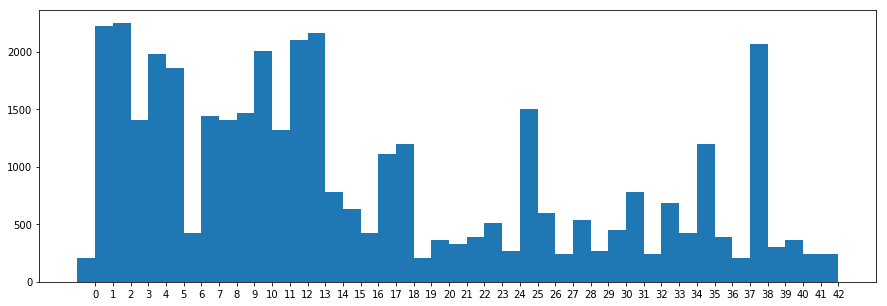

In [6]:
cls_counter = Counter()
y_train = []
for path in imgpaths:
    cls = int(path.split('/')[-2])
    y_train.append(cls)
    cls_counter[cls] += 1
    
labels, values = cls_counter.keys(), cls_counter.values()
indexes = np.arange(len(labels))

plt.figure(figsize=(15,5))
plt.bar(indexes, values, width=1)
plt.xticks(indexes + 0.5, labels)
plt.show()

In [7]:
sign_names_path = base_path + 'signnames.csv'
sign_names = pd.read_csv(sign_names_path, header=0)
sign_names.head(n_classes)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


As you can see, dataset is highly unbalanced. In order to avoid model overfitting let's balance classes manually

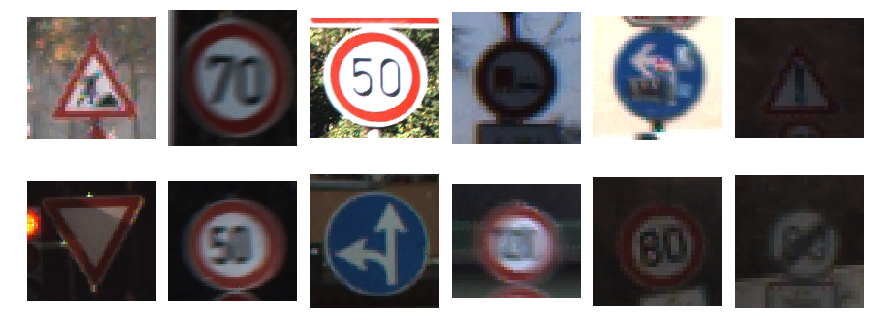

In [8]:
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=0.1, hspace=0)
plt.figure(figsize=(15, 6))

sample = np.random.choice(imgpaths, size=12)
for i, path in enumerate(sample):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    ax = plt.subplot(gs[i])
    ax.set_aspect('equal')    
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

In [9]:
def balance_dataset(imgpaths, cls_counter, max_count):
    sample_paths = np.array([])
    for i, count in cls_counter.items():
        if count < max_count:
            n_generate = max_count - count
            paths = [p for p in imgpaths if int(p.split('/')[-2]) == i]
            sample_paths = np.append(sample_paths, np.random.choice(paths, n_generate))
    return np.append(imgpaths, sample_paths)

In [10]:
imgpaths = balance_dataset(imgpaths, cls_counter, max_count=2000)
np.random.shuffle(imgpaths)
len(imgpaths)

86810

In [11]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(imgpaths, test_size=0.1, random_state=42)

n_train, n_valid = len(train), len(valid)
print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)

Number of training examples = 78129
Number of validation examples = 8681


In [12]:
train_gen = generator(train, n_classes=n_classes, batch_size=16, augment=True)
valid_gen = generator(valid, n_classes=n_classes, batch_size=16, augment=False)

In [13]:
model = get_model((32, 32, 3), n_classes=n_classes)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

## Train and validate model

After 20 epochs:
- train set: loss: 0.0317 - acc: 0.9905 
- validation set: val_loss: 0.0061 - val_acc: 0.9977

In [14]:
from keras.callbacks import ModelCheckpoint

weights_path = 'weights/tsrnet.hdf5'

try:
    model.load_weights(weights_path)
    print('Weights are loaded.')
except OSError:
    print('Weights of pretrained model were not found. Model should be trained first.')
    model.fit_generator(generator=train_gen,
        validation_data=valid_gen,
        steps_per_epoch=2000,
        validation_steps=400,
        epochs=20,
        verbose=1,
        callbacks=[
            ModelCheckpoint(weights_path, verbose=1, monitor='val_loss', save_best_only=True)
        ])

Weights are loaded.


## Evaluate model on test images

In [17]:
test_paths = [os.path.join(root, f).replace('\\', '/') 
              for root, _, files in os.walk(test_path) 
              for f in files if f.endswith('.ppm')]
print('Number of test examples =', len(test_paths))

Number of test examples = 12630


In [19]:
def get_top_n(prediction, sign_names, n=5):
    pred = list(prediction)
    classes, probs = [], []
    for i in range(n):
        index = np.argmax(pred)
        sign_name = sign_names[sign_names['ClassId'] == index]['SignName'].values[0]
        classes.append(sign_name)
        
        probs.append(max(pred))
        pred[index] = 0
    
    return classes, probs

In [22]:
imgpaths = np.random.choice(test_paths, 5)
images = []
for path in imgpaths:
    images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

In [ ]:
processed_images = np.zeros((len(images), 32, 32, 3))
for i, path in enumerate(imgpaths):
    processed_images[i] = get_image(path)
predictions = model.predict_on_batch(processed_images)

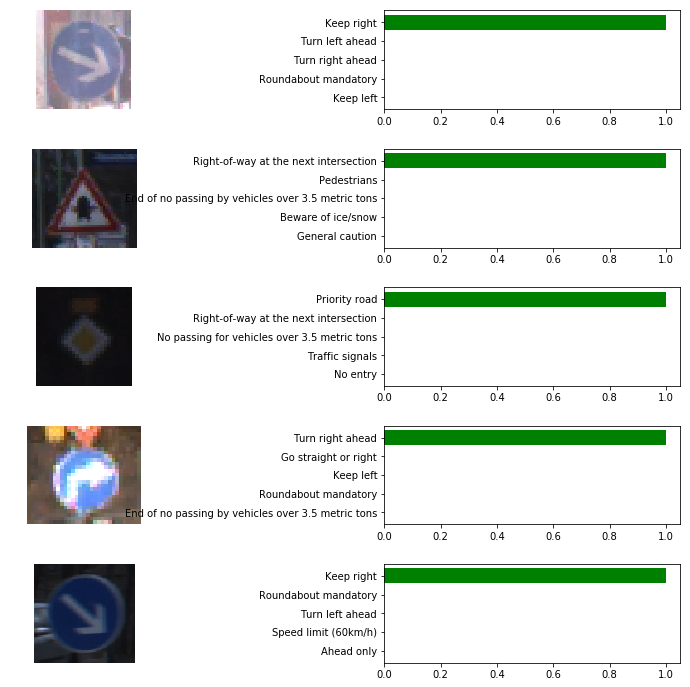

In [23]:
gs = gridspec.GridSpec(len(images), 2, width_ratios=[4, 2])
gs.update(wspace=0.01, hspace=0.4)
plt.figure(figsize=(16, 12))

for i in range(len(images)):
    ax = plt.subplot(gs[i, 0])
    ax.set_aspect('equal')    
    plt.imshow(images[i])
    plt.axis('off')
    
    signs, probs = get_top_n(predictions[i], sign_names)
    
    ax = plt.subplot(gs[i, 1])
    y_pos = np.arange(len(signs))    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(signs)
    ax.barh(y_pos, probs, align='center', color='green')
    ax.invert_yaxis()

## Evaluate model on images from web

In [26]:
web_paths = [os.path.join(root, f).replace('\\', '/') 
              for root, _, files in os.walk(web_path) 
              for f in files if f.endswith('.png')]
images = []
for path in web_paths:
    images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
n_web = len(images)
print(n_web)

5


In [27]:
processed_images = np.zeros((len(images), 32, 32, 3))
for i, path in enumerate(web_paths):
    processed_images[i] = get_image(path)
predictions = model.predict_on_batch(processed_images)

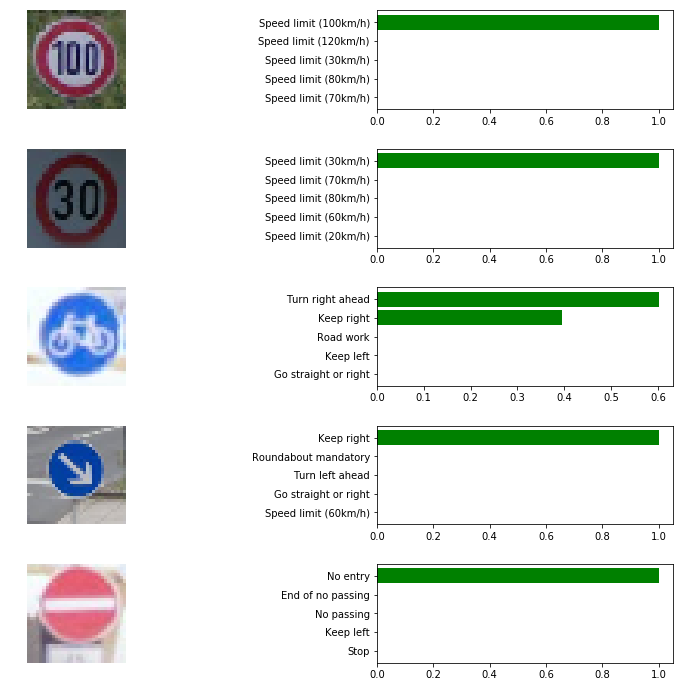

In [28]:
gs = gridspec.GridSpec(n_web, 2, width_ratios=[4, 2])
gs.update(wspace=0.01, hspace=0.4)
plt.figure(figsize=(16, 12))

for i in range(n_web):
    ax = plt.subplot(gs[i, 0])
    ax.set_aspect('equal')    
    plt.imshow(images[i])
    plt.axis('off')
    
    signs, probs = get_top_n(predictions[i], sign_names)
    
    ax = plt.subplot(gs[i, 1])
    y_pos = np.arange(len(signs))    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(signs)
    ax.barh(y_pos, probs, align='center', color='green')
    ax.invert_yaxis()

Model i pretty confused about Bicycles crossing sign (#29). The reight prediction is not even in top5.
Look at examples from dataset

In [31]:
bicycle_sign_class = 29

train_examples = [p for p in train if int(p.split('/')[-2]) == bicycle_sign_class]
valid_examples = [p for p in valid if int(p.split('/')[-2]) == bicycle_sign_class]

train_unique = list(set(train_examples))
valid_unique = list(set(valid_examples))

print('Number of class examples in train =', len(train_examples))
print('Number of unique examples in train =', len(train_unique))
print('Number of class examples in valid =', len(valid_examples))
print('Number of unique examples in valid =', len(valid_unique))

Number of class examples in train = 1800
Number of unique examples in train = 270
Number of class examples in valid = 200
Number of unique examples in valid = 141


### Train examples of Bicycles crossing sign (#29)

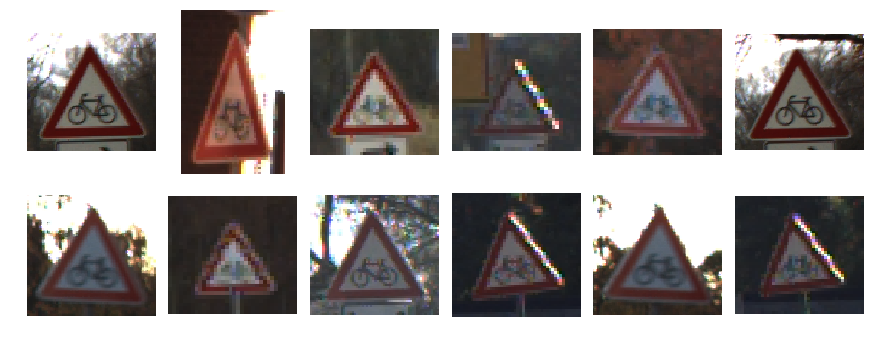

In [32]:
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=0.1, hspace=0)
plt.figure(figsize=(15, 6))

sample = np.random.choice(train_unique, size=12)
for i, path in enumerate(sample):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    ax = plt.subplot(gs[i])
    ax.set_aspect('equal')    
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

So that is the problem :) 
German Bicycles crossing sign looks in a slightly different way than the one presented in images from web.

### JFF

In [46]:
bgr_img = cv2.imread(sample[0])
img = (bgr_img.astype('float32') - 128) / 128
img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_LINEAR)

batch = np.zeros((1, 32, 32 ,3))
batch[0] = img
pred = model.predict(batch)

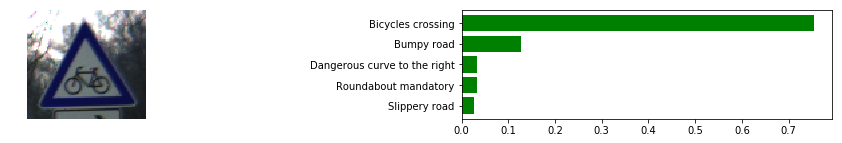

In [48]:
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
gs.update(wspace=0.01, hspace=0.4)
plt.figure(figsize=(20, 2))

ax = plt.subplot(gs[0, 0])
ax.set_aspect('equal')    
plt.imshow(bgr_img)
plt.axis('off')

signs, probs = get_top_n(pred[0], sign_names)

ax = plt.subplot(gs[0, 1])
y_pos = np.arange(len(signs))    
ax.set_yticks(y_pos)
ax.set_yticklabels(signs)
ax.barh(y_pos, probs, align='center', color='green')
ax.invert_yaxis()

Color channels ordering makes difference even in spite of the sign shape!